In [1]:
# Import essential libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import itertools
import keras
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import os
import cv2
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import regularizers
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
blood_cell_directory = os.path.join('', '../input/cnmc-leukemia/')

# creating a directory for all images present with us and bringing them under same directory
image_directory = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(blood_cell_directory, '*', '*.jpg'))}

In [3]:
count = 0
NotHealthyPaths = []
for dirname, _, filenames in os.walk(os.path.join(blood_cell_directory, 'Processed ALL')):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
                NotHealthyPaths.append(os.path.join(dirname, filename))
                count += 1

In [4]:
count = 0
HealthyPaths = []
for dirname, _, filenames in os.walk(os.path.join(blood_cell_directory, 'Processed Hem')):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
                HealthyPaths.append(os.path.join(dirname, filename))
                count += 1

In [5]:
df = pd.DataFrame(columns = ['path', 'label'])

In [6]:
# labels for Healthy:0, NotHealthy:1

for index1 in HealthyPaths:
    df=df.append({'path' : str(index1) , 'label' : 0} , ignore_index=True)
for index2 in NotHealthyPaths:
    df=df.append({'path' : str(index2) , 'label' : 1} , ignore_index=True)

In [7]:
df.tail()

,path,label
10656,../input/cnmc-leukemia/Processed ALL/image_Cla...,1
10657,../input/cnmc-leukemia/Processed ALL/image_Cla...,1
10658,../input/cnmc-leukemia/Processed ALL/image_Cla...,1
10659,../input/cnmc-leukemia/Processed ALL/image_Cla...,1
10660,../input/cnmc-leukemia/Processed ALL/image_Cla...,1


In [8]:
# Resizing images to 100 x 100
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [9]:
for index in range(len(df['image'])):
    img = Image.fromarray(df['image'][index])
    if img.mode == 'RGB':
        df['image'][index] = cv2.cvtColor(df['image'][index], cv2.COLOR_BGR2GRAY)

In [10]:
df.head()

,path,label,image
0,../input/cnmc-leukemia/Processed Hem/image_Cla...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,../input/cnmc-leukemia/Processed Hem/image_Cla...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,../input/cnmc-leukemia/Processed Hem/image_Cla...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,../input/cnmc-leukemia/Processed Hem/image_Cla...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,../input/cnmc-leukemia/Processed Hem/image_Cla...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


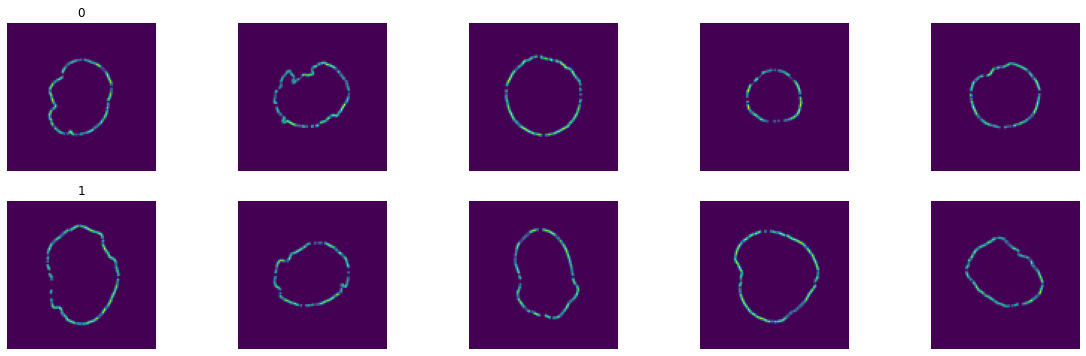

In [11]:
# Printing Sample images for each lesion type
n_samples = 5
num_classes = 2
fig, m_axs = plt.subplots(num_classes, n_samples, figsize = (4*n_samples, 3*num_classes))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)

In [13]:
Healthy = df.loc[df['label'] == 0]
features = np.asarray(Healthy['image'].tolist())

# Normalizing the data
data_mean = np.mean(features)
data_std = np.std(features)

Normilized_features = (features - data_mean)/data_std

In [14]:
Healthy_label = df.loc[df['label'] == 0]
labels = Healthy_label['label']
Normilized_features.shape

(3389, 100, 100)

In [15]:
Normilized_features = Normilized_features.reshape((Normilized_features.shape[0], 100, 100, 1))
Normilized_features = Normilized_features.astype('float32')
Normilized_features.shape

(3389, 100, 100, 1)

In [16]:
datagen.fit(Normilized_features)

In [17]:
Images = []
Image_Labels = []
for i in range(len(Normilized_features)):
    Images.append(Normilized_features[i])
    Image_Labels.append(labels[i])

In [18]:
from matplotlib import pyplot
for X_batch, y_batch in datagen.flow(Normilized_features, labels, batch_size=10):
    for j in range(len(X_batch)):
        X_batch[j] = np.asarray(X_batch[j])
        X_batch[j] = X_batch[j].astype('float32')
        Images.append(X_batch[j])
        Image_Labels.append(y_batch[j])
    print("-------------------")
    print(len(Images))
    if len(Images) > 4200:
        break

-------------------
3399
-------------------
3409
-------------------
3419
-------------------
3429
-------------------
3439
-------------------
3449
-------------------
3459
-------------------
3469
-------------------
3479
-------------------
3489
-------------------
3499
-------------------
3509
-------------------
3519
-------------------
3529
-------------------
3539
-------------------
3549
-------------------
3559
-------------------
3569
-------------------
3579
-------------------
3589
-------------------
3599
-------------------
3609
-------------------
3619
-------------------
3629
-------------------
3639
-------------------
3649
-------------------
3659
-------------------
3669
-------------------
3679
-------------------
3689
-------------------
3699
-------------------
3709
-------------------
3719
-------------------
3729
-------------------
3739
-------------------
3749
-------------------
3759
-------------------
3769
-------------------
3779
-------------------
3789


In [19]:
dataframe = pd.DataFrame(columns = ['image', 'label'])
for index in range(len(Image_Labels)):
    dataframe = dataframe.append({'image':Images[index]  , 'label': Image_Labels[index]} , ignore_index=True)

In [20]:
dataframe.head()

,image,label
0,"[[[-0.14523652], [-0.14523652], [-0.14523652],...",0
1,"[[[-0.14523652], [-0.14523652], [-0.14523652],...",0
2,"[[[-0.14523652], [-0.14523652], [-0.14523652],...",0
3,"[[[-0.14523652], [-0.14523652], [-0.14523652],...",0
4,"[[[-0.14523652], [-0.14523652], [-0.14523652],...",0


In [21]:
NotHealthy = df.loc[df['label'] == 1]
NotHealthy_features = np.asarray(NotHealthy['image'].tolist())

# Normalizing the data
data_mean = np.mean(NotHealthy_features)
data_std = np.std(NotHealthy_features)

NotHealthy_Normilized_features = (NotHealthy_features - data_mean)/data_std

NotHealthy_Normilized_features = NotHealthy_Normilized_features.reshape((NotHealthy_Normilized_features.shape[0], 100, 100, 1))
NotHealthy_Normilized_features = NotHealthy_Normilized_features.astype('float32')
NotHealthy_Normilized_features.shape

(7272, 100, 100, 1)

In [22]:
del Images
del Image_Labels
Images = []
Image_Labels = []
NotHealthy_labels = NotHealthy['label'].tolist()
for i in range(len(NotHealthy_Normilized_features)):
    Images.append(NotHealthy_Normilized_features[i])
    Image_Labels.append(NotHealthy_labels[i])

In [23]:
for index in range(len(Image_Labels)):
    if index <= 4200:
        dataframe = dataframe.append({'image':Images[index]  , 'label': Image_Labels[index]} , ignore_index=True)

In [24]:
dataframe.tail()

,image,label
8405,"[[[-0.16216828], [-0.16216828], [-0.16216828],...",1
8406,"[[[-0.16216828], [-0.16216828], [-0.16216828],...",1
8407,"[[[-0.16216828], [-0.16216828], [-0.16216828],...",1
8408,"[[[-0.16216828], [-0.16216828], [-0.16216828],...",1
8409,"[[[-0.16216828], [-0.16216828], [-0.16216828],...",1


In [25]:
dataframe.shape

(8410, 2)

In [26]:
data = np.asarray(dataframe['image'].tolist())

data_y = dataframe['label']

data = data.reshape(-1,10000)

In [27]:
df_cifar = pd.DataFrame(data)

In [28]:
df_cifar['label'] = dataframe['label']
print('Size of the dataframe: {}'.format(df_cifar.shape))

Size of the dataframe: (8410, 10001)


In [29]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
lower_dimension_data = pca.fit_transform(df_cifar.iloc[:,:-1])
lower_dimension_data.shape

(8410, 2066)

In [30]:
#Project lower dimension data onto original features
approximation = pca.inverse_transform(lower_dimension_data)
print(approximation.shape)
approximation = approximation.reshape(-1,100,100, 1)
X_norm = data
X_norm = X_norm.reshape(-1,100,100, 1)

(8410, 10000)


In [31]:
data = approximation

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2, random_state=42, shuffle=True)

In [33]:
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

In [34]:
del NotHealthy_Normilized_features
del data_mean
del data_std
del NotHealthy_features
del NotHealthy
del Normilized_features
del Healthy
del data
del approximation
del df
del X_norm
del lower_dimension_data
del dataframe
del Images
del Image_Labels

In [35]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [36]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [37]:
def ResNet(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='c')
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='c')
    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    #X = Dense(1200, activation='relu')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [38]:
model = ResNet(input_shape = (100, 100, 1), classes = 2)

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)
x_train.shape

(6728, 100, 100, 1)

In [41]:
# Fit data to model
history = model.fit(x_train, y_train,
            batch_size=32,
            epochs=10,
            verbose=1,
            callbacks=[learning_rate_reduction]
)

Epoch 1/10
211/211 [==============================] - 74s 353ms/step - loss: 0.1748 - accuracy: 0.9432
Epoch 2/10
211/211 [==============================] - 75s 355ms/step - loss: 0.0095 - accuracy: 0.9967
Epoch 3/10
211/211 [==============================] - 75s 354ms/step - loss: 4.9341e-04 - accuracy: 0.9999
Epoch 4/10
211/211 [==============================] - 73s 347ms/step - loss: 3.6264e-04 - accuracy: 0.9999
Epoch 5/10
211/211 [==============================] - 73s 348ms/step - loss: 7.4053e-05 - accuracy: 1.0000
Epoch 6/10
211/211 [==============================] - 73s 348ms/step - loss: 2.1012e-05 - accuracy: 1.0000
Epoch 7/10
211/211 [==============================] - 74s 349ms/step - loss: 9.6433e-06 - accuracy: 1.0000
Epoch 8/10
211/211 [==============================] - 73s 345ms/step - loss: 7.0468e-07 - accuracy: 1.0000
Epoch 9/10
211/211 [==============================] - 73s 346ms/step - loss: 1.4665e-06 - accuracy: 1.0000
Epoch 10/10
211/211 [========================

In [42]:
model.save('PreTrained_C_NMC_FeatureExtractor.h5')

In [43]:
FeatureExtractor_Model = Model(inputs = model.input, outputs = model.layers[-2].output, name='FeatureExtractor_ResNet')

In [44]:
# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [45]:
def feature_extraction(inputs, model):
    features = model.predict(inputs[0:100])
    for i in range(100, len(inputs), 100):
        feature = model.predict(inputs[i:i+100])
        features = np.concatenate((features, feature), axis=0)
        print("Processing Images From: ", int(i), "to: ", int(i+100))
    return features

In [46]:
features_resnet_C_NMC = feature_extraction(inputs, FeatureExtractor_Model)

Processing Images From:  100 to:  200
Processing Images From:  200 to:  300
Processing Images From:  300 to:  400
Processing Images From:  400 to:  500
Processing Images From:  500 to:  600
Processing Images From:  600 to:  700
Processing Images From:  700 to:  800
Processing Images From:  800 to:  900
Processing Images From:  900 to:  1000
Processing Images From:  1000 to:  1100
Processing Images From:  1100 to:  1200
Processing Images From:  1200 to:  1300
Processing Images From:  1300 to:  1400
Processing Images From:  1400 to:  1500
Processing Images From:  1500 to:  1600
Processing Images From:  1600 to:  1700
Processing Images From:  1700 to:  1800
Processing Images From:  1800 to:  1900
Processing Images From:  1900 to:  2000
Processing Images From:  2000 to:  2100
Processing Images From:  2100 to:  2200
Processing Images From:  2200 to:  2300
Processing Images From:  2300 to:  2400
Processing Images From:  2400 to:  2500
Processing Images From:  2500 to:  2600
Processing Images

In [47]:
print("Shape of Extracted Features:", features_resnet_C_NMC.shape)
print("Shape of Outputs:", targets.shape)

Shape of Extracted Features: (8410, 2304)
Shape of Outputs: (8410, 2)


In [48]:
np.save("C_NMC_ExtractedFeatures.npy", features_resnet_C_NMC)
np.save("Targets.npy", targets)